# 📘 Reproduce Option Pricing Results from Pretrained Models

This notebook evaluates pretrained models for option pricing using preprocessed and scaled financial data. It reproduces evaluation metrics and prediction scatter plots for three selected models:

- **FNN_AllFeatures**
- **LSTM_AttnFusion**
- **CrossAttention_LSTM**

These results correspond to one trial from the original experimental notebook. Evaluation can be run on either a local CPU or Google Colab.

> ⚠️ **Note:** The Black-Scholes model benchmark is **not included**, as it requires access to raw financial inputs (e.g., underlying asset prices, volatility, time to maturity), which are not provided due to licensing restrictions.

## 🔐 Data Compliance

In accordance with the **OptionsMetrics license**, raw financial data cannot be distributed. To comply:

- The file `inference_eval.csv` contains **processed, scaled, and anonymized** features.
- **Only the target scaler** is provided for inverse transformation of predictions.
- All **feature scalers are hidden**.
- **Date columns** have been removed to ensure data irreversibility.

This setup ensures that results are reproducible without exposing any original or reverse-engineerable financial data.


## 🗒️ Original Code

The **full original training and evaluation notebook** (including data processing, model training, and benchmarking code) is also provided in this repository as a separate file for reference.

## 📂 Directory Structure

All required files should be placed in:

- `/models/` — pretrained model `.pt` files  
- `/data/` — `inference_eval.csv` (processed input data)


In [ ]:
# --- Setup ---
import os
from pathlib import Path
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import Dataset, DataLoader
import joblib

SCALER_DIR = Path('./scalers')
DATA_PATH = Path('./data/inference_eval.csv')
MODEL_DIR = Path('./models')
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
WINDOW = 10

MACRO_COLS = ['10y_treasury']
SENTIMENT_COLS = ['sentiment_score', 'market_sentiment']
OPTION_COLS = ['vix_price', 'spx_price', 'impl_volatility',
               'moneyness', 'open_interest', 'greeks_signal_1']
ALL_COLS = MACRO_COLS + SENTIMENT_COLS + OPTION_COLS
TARGET_COL = 'target_option_price'

In [ ]:
# --- Load Scalers ---
target_scaler = joblib.load(SCALER_DIR / 'target_scaler.pkl')

In [ ]:
# --- Load and Split Data ---
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()

test_df = df.copy()
test_full = test_df.copy()
test_red = test_df.copy()


In [ ]:
# --- Inference Dataset ---
class InferenceDataset(Dataset):
    def __init__(self, df, window, mode, groups):
        self.mode = mode
        self.window = window
        fmap = {'macro': MACRO_COLS, 'sentiment': SENTIMENT_COLS, 'options': OPTION_COLS}
        self.cols = sum([fmap[g] for g in groups], [])
        self.modal_cols = {k: [c for c in self.cols if c in v] for k, v in fmap.items()}
        self.samples = []
        for i in range(len(df) - window):
            win = df.iloc[i:i+window]
            y = df.iloc[i+window][TARGET_COL]
            if mode == 'flat':
                x = win[self.cols].values.flatten()
                self.samples.append((x, y))
            elif mode == 'early_fusion':
                x = win[self.cols].values
                self.samples.append((x, y))
            elif mode == 'multimodal':
                m = win[self.modal_cols['macro']].values
                s = win[self.modal_cols['sentiment']].values
                o = win[self.modal_cols['options']].values
                self.samples.append((m, s, o, y))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        item = self.samples[idx]
        if self.mode in ('flat', 'early_fusion'):
            x, y = item
            return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        else:
            m, s, o, y = item
            return (torch.tensor(m, dtype=torch.float32),
                    torch.tensor(s, dtype=torch.float32),
                    torch.tensor(o, dtype=torch.float32),
                    torch.tensor(y, dtype=torch.float32))

In [ ]:
# --- Inference Dataset Selector ---
def get_dataset(df, mode, groups):
    return InferenceDataset(df, WINDOW, mode, groups)

In [ ]:
# ---- Helper to build MLP ----
def build_mlp(in_dim, hidden, drop):
    layers = []
    for h, d in zip(hidden, drop):
        layers += [nn.Linear(in_dim, h), nn.ReLU()]
        if d > 0: layers.append(nn.Dropout(d))
        in_dim = h
    layers.append(nn.Linear(in_dim, 1))
    return nn.Sequential(*layers)

# ---- Sub‑modules ----
class LSTMSubNet(nn.Module):
    def __init__(self, in_size, h_size, n_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(in_size, h_size, num_layers=n_layers,
                            batch_first=True, dropout=dropout if n_layers>1 else 0.)
        self.fc = nn.Linear(h_size, h_size)
    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])

# ---- 1) Feed‑forward (options only) ----
class OptionsOnlyFNN(nn.Module):
    def __init__(self, in_dim, hidden, drop):
        super().__init__()
        self.net = build_mlp(in_dim, hidden, drop)
    def forward(self, x): return self.net(x).squeeze(-1)

# ---- 2) Feed‑forward (all features) ----
class EarlyFusionFNN(nn.Module):
    def __init__(self, in_dim, hidden, drop):
        super().__init__()
        self.net = build_mlp(in_dim, hidden, drop)
    def forward(self, x): return self.net(x).squeeze(-1)

# ---- 3) LSTM (options only) ----
class LSTMOptionsOnly(nn.Module):
    def __init__(self, in_size, h, layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(in_size, h, num_layers=layers, batch_first=True,
                            dropout=dropout if layers>1 else 0.)
        self.fc = nn.Sequential(nn.BatchNorm1d(h), nn.ReLU(), nn.Dropout(dropout),
                                nn.Linear(h,1))
    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1]).squeeze(-1)

# ---- 4) Bidirectional LSTM (early fusion) ----
class LSTMEarlyFusion(nn.Module):
    def __init__(self, in_size, h, layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(in_size, h, num_layers=layers, batch_first=True,
                            dropout=dropout if layers>1 else 0., bidirectional=True)
        self.fc = nn.Sequential(nn.Linear(h*2, h), nn.ReLU(), nn.Linear(h,1))
    def forward(self, x):
        _, (h, _) = self.lstm(x)
        h_cat = torch.cat((h[-2], h[-1]), dim=1)
        return self.fc(h_cat).squeeze(-1)

# ---- 5) Multimodal LSTM ----
class LSTMMultimodal(nn.Module):
    def __init__(self, sizes, h, layers, drop):
        super().__init__()
        self.mac = LSTMSubNet(sizes[0], h, layers, drop)
        self.sent= LSTMSubNet(sizes[1], h, layers, drop)
        self.opt = LSTMSubNet(sizes[2], h, layers, drop)
        self.fuse= nn.Sequential(nn.Linear(h*3,128), nn.ReLU(), nn.Dropout(drop),
                                 nn.Linear(128,h), nn.ReLU(), nn.Linear(h,1))
    def forward(self, m, s, o):
        x = torch.cat([self.mac(m), self.sent(s), self.opt(o)], dim=1)
        return self.fuse(x).squeeze(-1)

# ---- 6) Attention‑fusion LSTM ----
class AttentionFusionLSTM(nn.Module):
    def __init__(self, sizes, h, layers, drop):
        super().__init__()
        self.mac = LSTMSubNet(sizes[0], h, layers, drop)
        self.sent= LSTMSubNet(sizes[1], h, layers, drop)
        self.opt = LSTMSubNet(sizes[2], h, layers, drop)

        self.pos = nn.Parameter(torch.randn(1, 3, h))
        self.attn = nn.MultiheadAttention(h, 1, batch_first=True)
        self.norm = nn.LayerNorm(h)

        self.out = nn.Sequential(
            nn.Linear(h, h//2),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(h//2, 1)
        )

    def forward(self, m, s, o, return_attention=False):
        x = torch.stack([self.mac(m), self.sent(s), self.opt(o)], dim=1) + self.pos
        z, attn_weights = self.attn(x, x, x, need_weights=True)
        z = self.norm(z + x).mean(1)
        out = self.out(z).squeeze(-1)

        if return_attention:
            return out, attn_weights  # shape: (batch_size, num_heads=1, tokens=3)
        return out

# ---- 7) Cross‑attention LSTM ----
class CrossAttentionLSTM(nn.Module):
    def __init__(self, sizes, h, layers, drop):
        super().__init__()
        self.mac_lstm = nn.LSTM(sizes[0], h, num_layers=layers, batch_first=True, dropout=drop if layers>1 else 0.)
        self.sent_lstm = nn.LSTM(sizes[1], h, num_layers=layers, batch_first=True, dropout=drop if layers>1 else 0.)
        self.opt_lstm = nn.LSTM(sizes[2], h, num_layers=layers, batch_first=True, dropout=drop if layers>1 else 0.)

        # Sent attends to Macro, and Macro attends to Sent
        self.sent2mac_attn = nn.MultiheadAttention(h, 1, batch_first=True)
        self.mac2sent_attn = nn.MultiheadAttention(h, 1, batch_first=True)

        self.fuse = nn.Sequential(
            nn.LayerNorm(h * 3),  # Concatenate: opt, sent->mac, mac->sent
            nn.Linear(h * 3, 128),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(128, 1)
        )

    def forward(self, mac, sent, opt):
        mac_seq, _ = self.mac_lstm(mac)     # (B, T, H)
        sent_seq, _ = self.sent_lstm(sent)  # (B, T, H)
        opt_seq, _ = self.opt_lstm(opt)     # (B, T, H)

        # Sentiment attends to Macro
        sent2mac, _ = self.sent2mac_attn(sent_seq, mac_seq, mac_seq)

        # Macro attends to Sentiment
        mac2sent, _ = self.mac2sent_attn(mac_seq, sent_seq, sent_seq)

        # Feature summary: mean of sequences
        sent2mac_feat = sent2mac.mean(1)
        mac2sent_feat = mac2sent.mean(1)
        opt_feat = opt_seq.mean(1)

        feat = torch.cat([opt_feat, sent2mac_feat, mac2sent_feat], dim=1)
        return self.fuse(feat).squeeze(-1)

In [ ]:
def evaluate(model, loader, mode):
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for batch in loader:
            if mode in ('flat', 'early_fusion'):
                x, y = batch
                x = x.to(DEVICE)
                y_hat = model(x)
            elif mode == 'multimodal':
                m, s, o, y = batch
                m, s, o = m.to(DEVICE), s.to(DEVICE), o.to(DEVICE)
                y_hat = model(m, s, o)
            else:
                raise ValueError(f"Unsupported mode: {mode}")

            preds.extend(y_hat.cpu().numpy())
            trues.extend(y.cpu().numpy())

    preds = np.array(preds).reshape(-1, 1)
    trues = np.array(trues).reshape(-1, 1)

    preds = target_scaler.inverse_transform(preds).flatten()
    trues = target_scaler.inverse_transform(trues).flatten()

    return {
        'mae': mean_absolute_error(trues, preds),
        'rmse': np.sqrt(mean_squared_error(trues, preds)),
        'r2': r2_score(trues, preds),
        'y': trues,
        'y_hat': preds
    }

⏳ Evaluating FNN_AllFeatures...


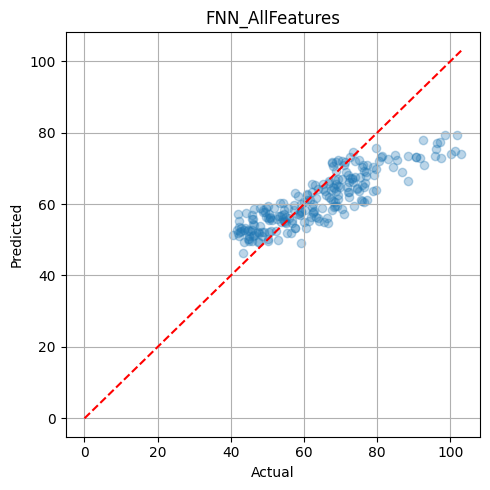

⏳ Evaluating LSTM_AttnFusion...


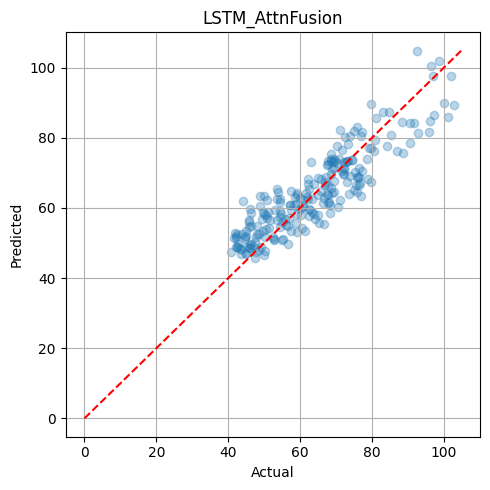

⏳ Evaluating CrossAttention_LSTM...


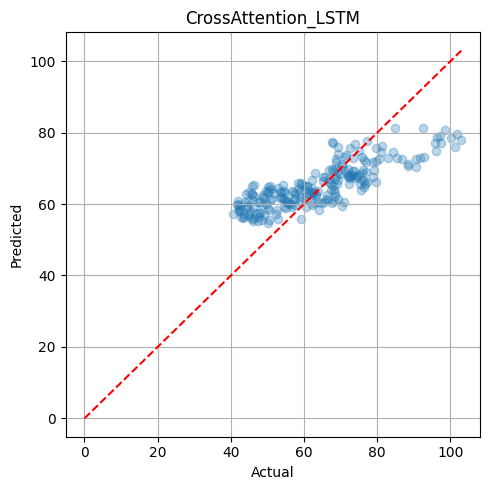

In [ ]:
# --- 5. Model Evaluation Loop ---
model_registry = {
    'FNN_AllFeatures': dict(
        cls=EarlyFusionFNN,
        args=dict(in_dim=(len(MACRO_COLS) + len(SENTIMENT_COLS) + len(OPTION_COLS)) * WINDOW,
                  hidden=[64,192, 384, 512],
                  drop=[0.21690647686746356, 0.17333303298100486, 0.051245528433709775, 0.28461553354003577]),
        lr=3.619917167764799e-05, epochs=200,
        mode='flat',
        groups=['macro', 'sentiment', 'options']
    ),

    'LSTM_AttnFusion': dict(
        cls=AttentionFusionLSTM,
        args=dict(sizes=[len(MACRO_COLS), len(SENTIMENT_COLS), len(OPTION_COLS)],
                  h=96, layers=1, drop=0.22167129082131226),
        lr=0.00031653476644270535, epochs=60,
        mode='multimodal',
        groups=['macro', 'sentiment', 'options']
    ),

    'CrossAttention_LSTM': dict(
        cls=CrossAttentionLSTM,
        args=dict(sizes=[len(MACRO_COLS), len(SENTIMENT_COLS), len(OPTION_COLS)],
                  h=128, layers=3, drop=0.4087067551985453),
        lr=0.000357889995198984, epochs=60,
        mode='multimodal',
        groups=['macro', 'sentiment', 'options']
    )
}


results = {}

for name, meta in model_registry.items():
    print(f"⏳ Evaluating {name}...")
    model = meta['cls'](**meta['args']).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_DIR / f"{name}.pt", map_location=DEVICE))

    # Select the correct test set
    if meta['mode'] == 'flat':
        ds_df = test_full
    else:
        ds_df = test_red

    ds = get_dataset(ds_df, meta['mode'], meta['groups'])
    loader = DataLoader(ds, batch_size=32)

    res = evaluate(model, loader, meta['mode'])
    results[name] = res

    # Plot predictions
    plt.figure(figsize=(5, 5))
    plt.scatter(res['y'], res['y_hat'], alpha=0.3)
    lim = max(max(res['y']), max(res['y_hat']))
    plt.plot([0, lim], [0, lim], 'r--')
    plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.title(name)
    plt.grid(True); plt.tight_layout(); plt.show()


In [ ]:
# --- 7. Final Scoreboard ---
print('\n🏁 Model Scoreboard:')
for name, res in results.items():
    print(f"{name:<20} MAE: {res['mae']:.4f}  RMSE: {res['rmse']:.4f}  R²: {res['r2']:.4f}")



🏁 Model Scoreboard:
FNN_AllFeatures      MAE: 7.0893  RMSE: 9.0680  R²: 0.6119
LSTM_AttnFusion      MAE: 5.4435  RMSE: 6.5844  R²: 0.7954
CrossAttention_LSTM  MAE: 8.2425  RMSE: 10.0915  R²: 0.5194
